## Imports

In [1]:
from nb_utils import set_root

PROJECT_DIR = set_root(4, "src")

In [2]:
import warnings

import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor

from mlpr.ml.supervisioned.regression import metrics, plots
from mlpr.ml.supervisioned.tunning.grid_search import GridSearch

# from mlpr.reports.create import ReportGenerator
# from utils.reader import read_file_yaml

warnings.filterwarnings("ignore")

%reload_ext autoreload

## Parameters

In [3]:
path_data = PROJECT_DIR / 'data'
path_conf = PROJECT_DIR / 'conf'
path_templates = PROJECT_DIR / 'templates'
path_assets = PROJECT_DIR / 'assets'

path_intermediate = path_data / '02_intermediate'
path_models = path_data / '04_models'
path_reports = path_data / '05_reports'

path_reports_regression = path_templates / "regression"
file_path_reports = path_reports / "report_model.html"

n_seed: int = 42

In [4]:
np.random.seed(n_seed)

## Methods

In [5]:
def rmse(y_true: np.ndarray, y_pred: np.ndarray):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

## Read

In [6]:
n_feats = 11
n_instances = 1000
n_invert = 50

X, y = make_regression(n_samples=n_instances, n_features=n_feats, noise=20)

indices: np.ndarray = np.random.choice(y.shape[0], size=n_invert, replace=False)
y[indices] = np.max(y) - y[indices]

data = pd.DataFrame(data=X, columns=[f'feature_{i}' for i in range(1, n_feats + 1)])
data['target'] = y

## Split labels

In [7]:
X: pd.DataFrame = data.drop("target", axis=1)
y: np.ndarray = data["target"].values

## Modelling

In [8]:
models_params = {
    Ridge: {
        'alpha': [1.0, 10.0, 15., 20.],
        'random_state': [n_seed]
    },
    Lasso: {
        'alpha': [0.1, 1.0, 10.0],
        'random_state': [n_seed]
    },
    SVR: {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf']
    },
    RandomForestRegressor: {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10],
        'random_state': [n_seed]
    },
    GradientBoostingRegressor: {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'random_state': [n_seed]
    },
    XGBRegressor: {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'random_state': [n_seed]
    }
}

params_split: dict[str, float | int] = {
    'test_size': 0.25,
    'random_state': n_seed
}
params_norm: dict[str, bool] = {'with_mean': True, 'with_std': True}

grid_search = GridSearch(
    X,
    y,
    params_split=params_split,
    models_params=models_params,
    normalize=True,
    scoring='neg_mean_squared_error',
    metrics={'neg_mean_squared_error': rmse},
    params_norm=params_norm
)
grid_search.search(cv=5, n_jobs=-1)

best_model, best_params = \
    grid_search \
    .get_best_model()

100%|██████████| 6/6 [00:35<00:00,  5.95s/it]


## Predictions

In [9]:
data_train = pd.DataFrame(
    grid_search.X_train,
    columns=X.columns
)
data_train["y_true"] = grid_search.y_train
data_train["y_pred"] = grid_search.best_model.predict(grid_search.X_train)

In [10]:
pd.DataFrame(grid_search._metrics).T

,neg_mean_squared_error
Ridge,-93.412630
Lasso,-93.567748
SVR,-88.968969
RandomForestRegressor,-135.315408
GradientBoostingRegressor,-128.552745
XGBRegressor,-133.876744


In [11]:
grid_search.best_model

SVR(kernel='linear')

## Metrics

In [12]:
k = 3
rm = metrics.RegressionMetrics(data_train, *["y_true", "y_pred"])

In [13]:
results: dict = rm.calculate_metrics(
    ["mape", "rmse", "kolmogorov_smirnov", "confusion_matrix", "calculate_kappa"],
    {
        "mape": {},
        "rmse": {},
        "kolmogorov_smirnov": {},
        "confusion_matrix": {"n_bins": k},
        "calculate_kappa": {"n_bins": k}
    }
)

## Plots

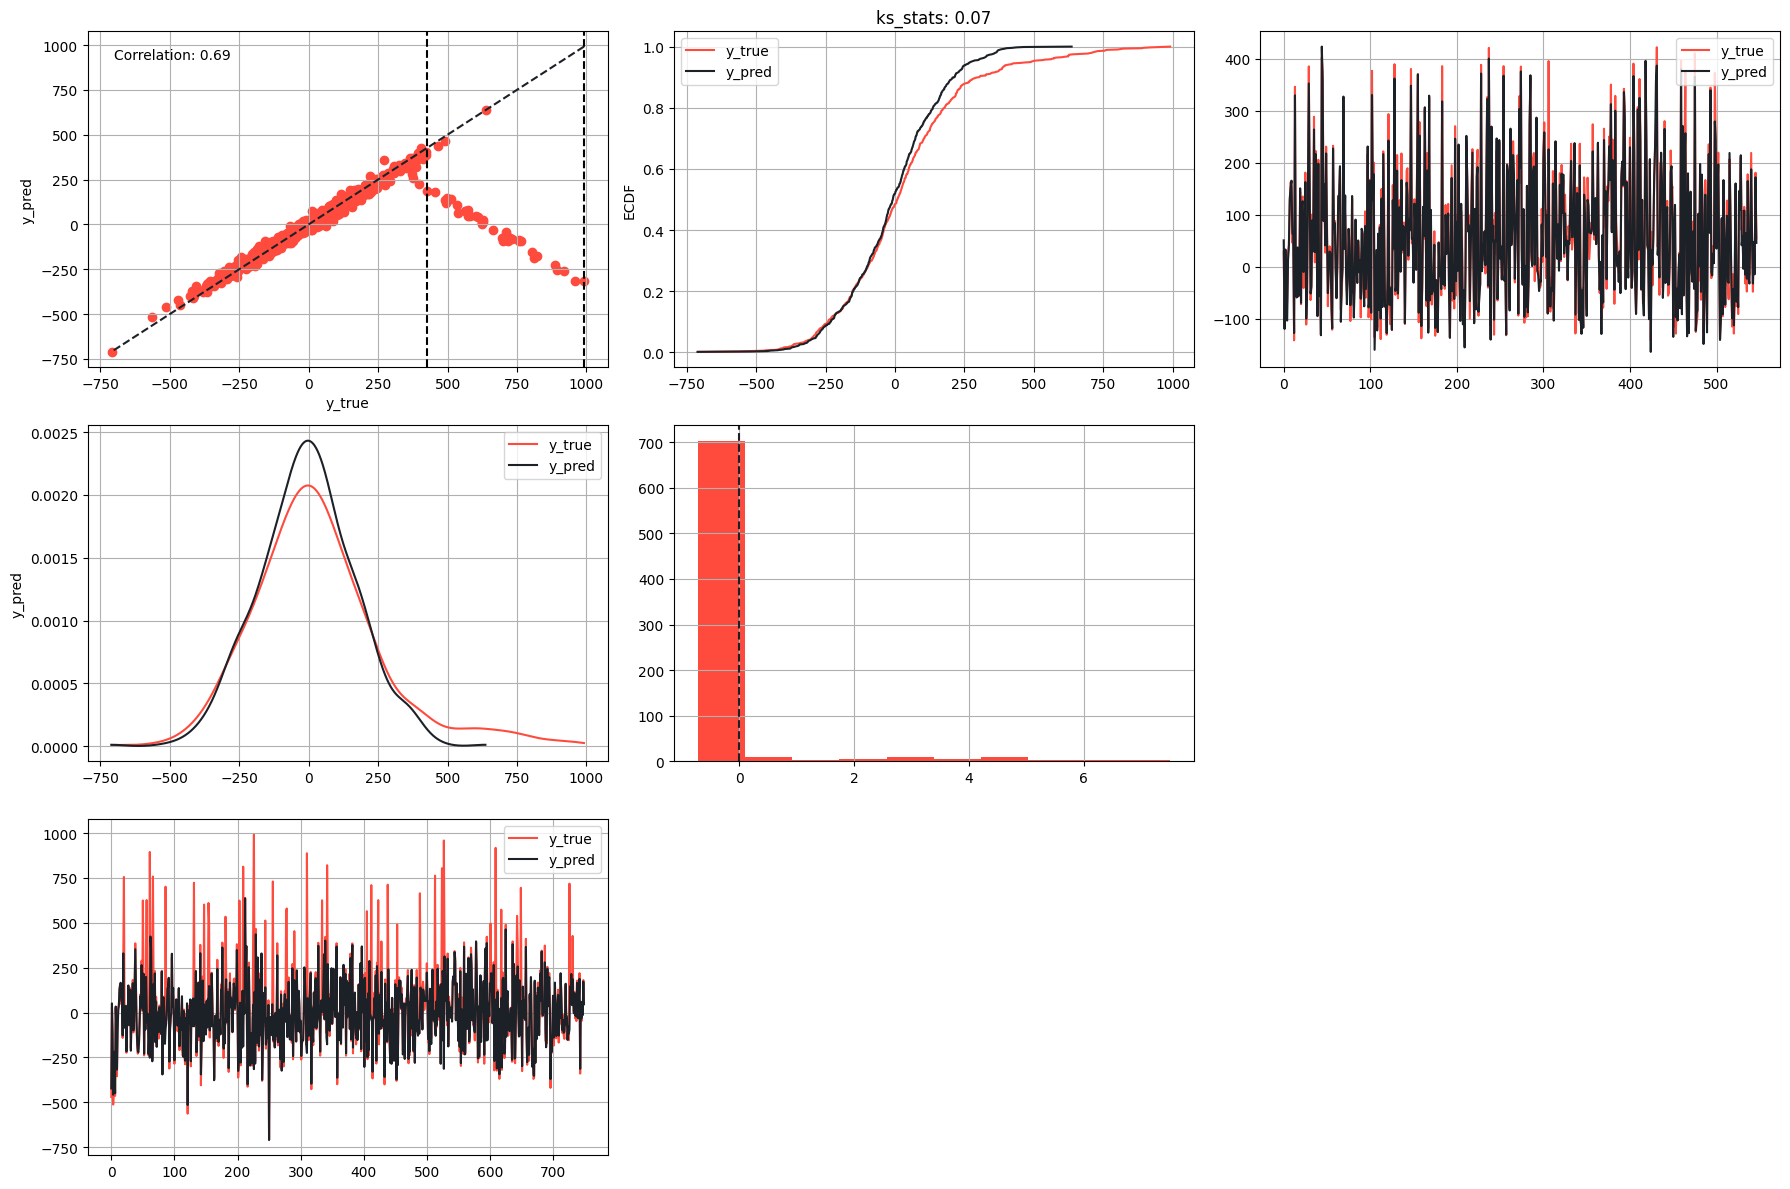

In [14]:
rp = plots.RegressionPlots(data_train, color_palette=["#FF4B3E", "#1C2127"])
fig, axs = rp.grid_plot(
    plot_functions=[
        ['graph11', 'graph12', 'graph13'],
        ['graph21', 'graph22', ''],
        ['graph23', '', '']
    ],
    plot_args={
        'graph11': {
            "plot": "scatter",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'linecolor': '#1C2127',
                'worst_interval': True,
                'metrics': rm.metrics["calculate_kappa"],
                'class_interval': rm._class_intervals,
                'method': 'recall',
                'positive': True
            }
        },
        'graph12': {
            "plot": "plot_ecdf",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred'
            }
        },
        'graph21': {
            "plot": "plot_kde",
            "params": {
                'columns': ['y_true', 'y_pred']
            }
        },
        'graph22': {
            "plot": "plot_error_hist",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'linecolor': '#1C2127'
            }
        },
        'graph13': {
            "plot": "plot_fitted",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'condition': (
                    (
                        rm._worst_interval_kappa[0] <= data_train["y_true"]
                    ) & (
                        data_train["y_true"] <= rm._worst_interval_kappa[1]
                    )
                ),
                'sample_size': None
            }
        },
        'graph23': {
            "plot": "plot_fitted",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'condition': None,
                'sample_size': None
            }
        },
    },
    show_inline=True
)

## Save image

In [ ]:
# fig.savefig(
#     path_assets / "regression_plots.png",
#     dpi=400,
#     bbox_inches='tight'
# )

## Reports

In [ ]:
# report = ReportGenerator(template_dir=path_reports_regression)
# report.render(
#     metrics=results,
#     template_file="template_v3.html",
#     output_file=file_path_reports,
#     image_path=path_intermediate / "regression_plots.png"
# )